<a href="https://colab.research.google.com/github/uribalb/PlacesRecommender/blob/master/EDA_DP/YelpUsersRestaurants.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

review_restaurants = pd.read_csv('/content/drive/MyDrive/recommender_dataset/Yelp/yelp_dataset/yelp_review_restaurants_sentiment.csv')
df_users = pd.read_csv('/content/drive/MyDrive/recommender_dataset/Yelp/yelp_dataset/yelp_users.csv')
df_restaurants = pd.read_csv('/content/drive/MyDrive/recommender_dataset/Yelp/yelp_dataset/yelp_restaurants.csv')


In [3]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125 entries, 0 to 1124
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             1125 non-null   object 
 1   name                1125 non-null   object 
 2   review_count        1125 non-null   int64  
 3   yelping_since       1125 non-null   object 
 4   useful              1125 non-null   int64  
 5   funny               1125 non-null   int64  
 6   cool                1125 non-null   int64  
 7   elite               316 non-null    object 
 8   friends             870 non-null    object 
 9   fans                1125 non-null   int64  
 10  average_stars       1125 non-null   float64
 11  compliment_hot      1125 non-null   int64  
 12  compliment_more     1125 non-null   int64  
 13  compliment_profile  1125 non-null   int64  
 14  compliment_cute     1125 non-null   int64  
 15  compliment_list     1125 non-null   int64  
 16  compli

In [4]:
df_restaurants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   114 non-null    object 
 1   name          114 non-null    object 
 2   address       114 non-null    object 
 3   city          114 non-null    object 
 4   state         114 non-null    object 
 5   postal_code   114 non-null    object 
 6   latitude      114 non-null    float64
 7   longitude     114 non-null    float64
 8   stars         114 non-null    float64
 9   review_count  114 non-null    int64  
 10  is_open       114 non-null    int64  
 11  attributes    109 non-null    object 
 12  categories    114 non-null    object 
 13  hours         11 non-null     object 
dtypes: float64(3), int64(2), object(9)
memory usage: 12.6+ KB


In [5]:
df_restaurants.iloc[0]['attributes']

'{\'BusinessAcceptsCreditCards\': \'True\', \'RestaurantsDelivery\': \'False\', \'RestaurantsTakeOut\': \'False\', \'RestaurantsGoodForGroups\': \'True\', \'GoodForKids\': \'False\', \'RestaurantsPriceRange2\': \'3\', \'RestaurantsAttire\': "\'casual\'", \'BusinessParking\': "{\'garage\': False, \'street\': True, \'validated\': False, \'lot\': False, \'valet\': False}", \'Alcohol\': "u\'full_bar\'", \'RestaurantsReservations\': \'True\', \'OutdoorSeating\': \'True\'}'

In [6]:
# display all distinct values of 'city' in 'df_restaurants' with a count for each

df_restaurants['city'].value_counts()


city
Philadelphia        23
Tucson               8
New Orleans          7
Saint Louis          7
Edmonton             7
Tampa                6
Santa Barbara        5
Nashville            4
Camden               3
Boise                2
Port Richey          2
Saint Petersburg     2
Clearwater           2
Sellersville         1
Mount Juliet         1
Chesterfield         1
Hainesport           1
Saint Rose           1
Trenton              1
Moorestown           1
King of Prussia      1
Meridian             1
Coatesville          1
Marlton              1
Metairie             1
West Chester         1
Indianapolis         1
Wilmington           1
Oaklyn               1
Greenwood            1
Florissant           1
Pottstown            1
Collingswood         1
Reno                 1
Edwardsville         1
Goodlettsville       1
Dupo                 1
Lansdowne            1
Cherry Hill          1
Greenville           1
Belleville           1
Pennsville           1
Kenner               1
Pleasa

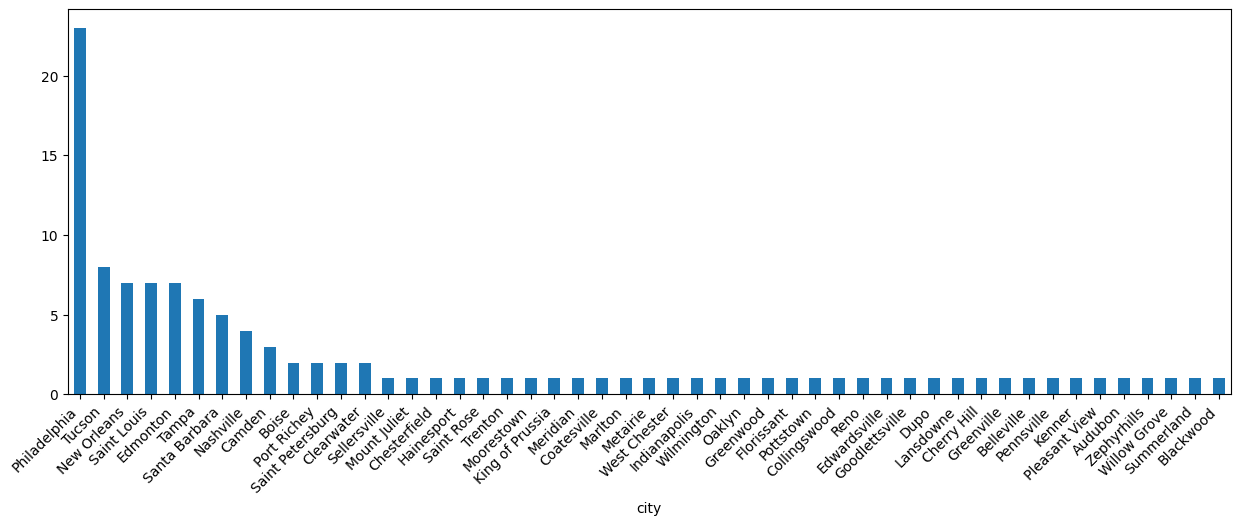

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
df_restaurants['city'].value_counts().plot(kind='bar')
plt.xticks(rotation=45, ha='right')
plt.show()


## Visualization of Restaurants attributes

In [8]:
import numpy as np
# Extract numerical attributes from 'df_restaurants'
df_restaurants_num = df_restaurants.select_dtypes(include=np.number)


In [9]:
num_attr_ranges = {}
for col in df_restaurants_num.columns:
  num_attr_ranges[col] = (df_restaurants_num[col].min(), df_restaurants_num[col].max())

print(num_attr_ranges)

{'latitude': (27.7693413, 53.6002702), 'longitude': (-119.818231, -74.78838089999999), 'stars': (1.0, 5.0), 'review_count': (5, 56), 'is_open': (0, 1)}


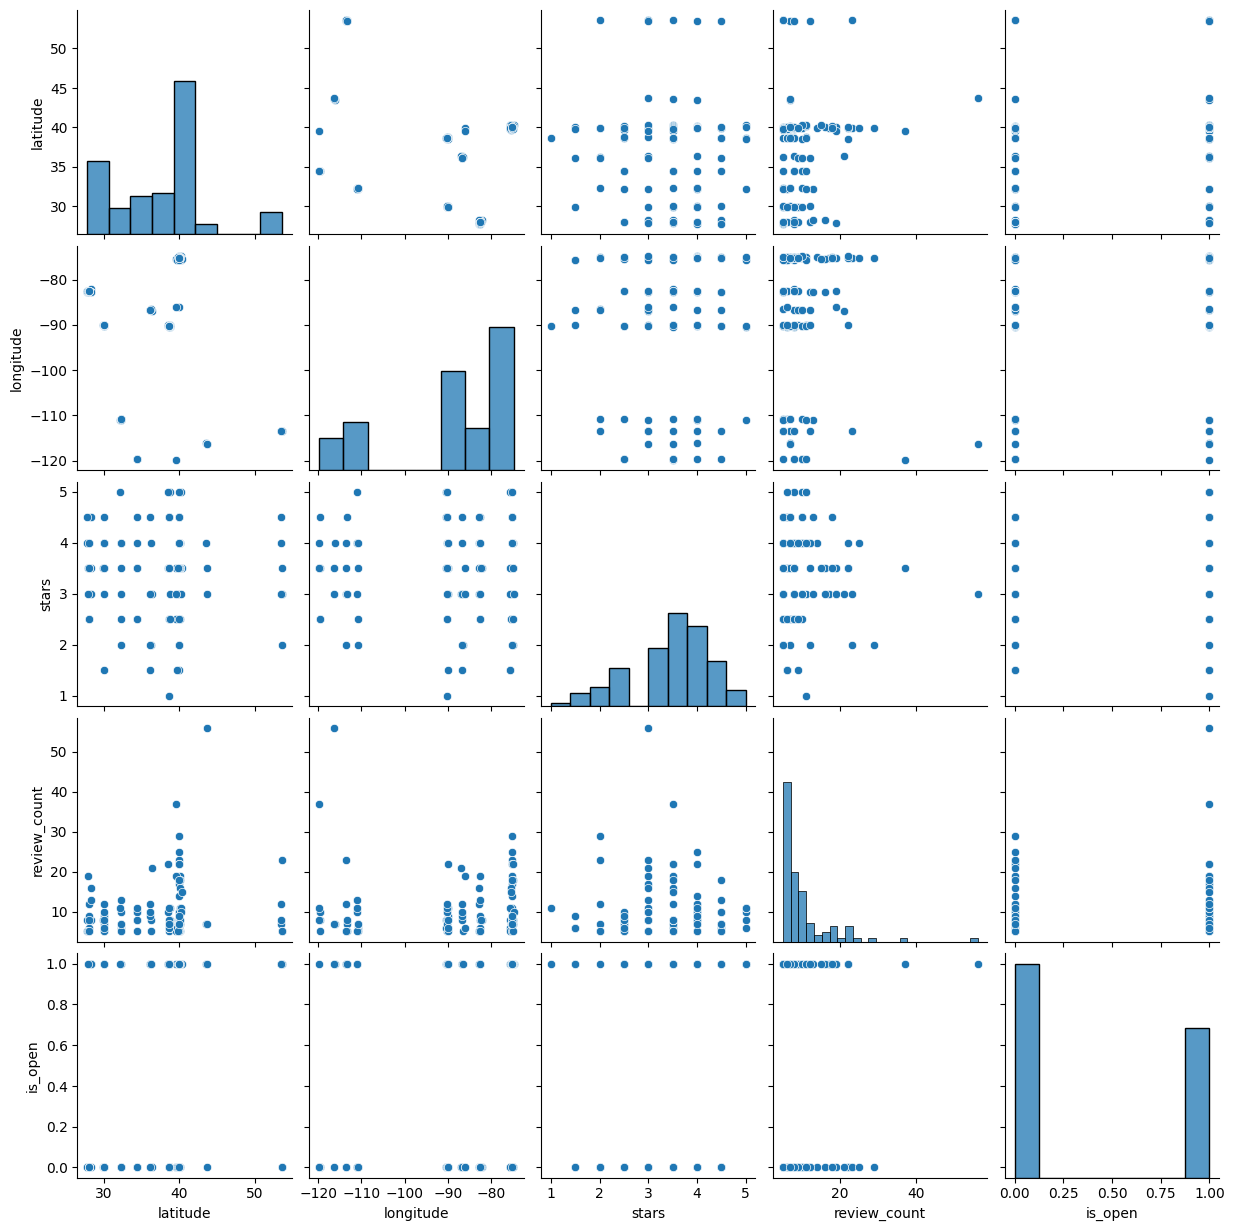

In [10]:
import seaborn as sns

sns.pairplot(df_restaurants_num)


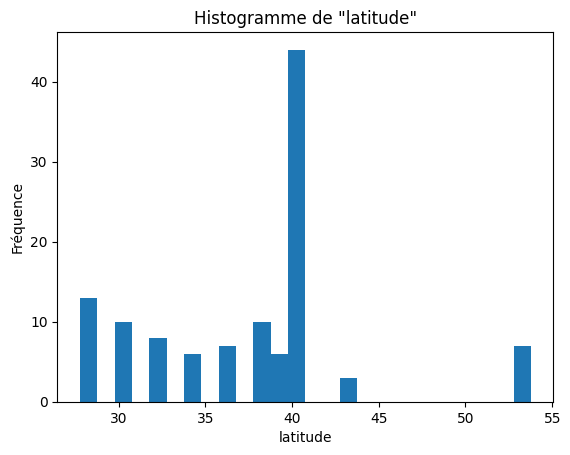

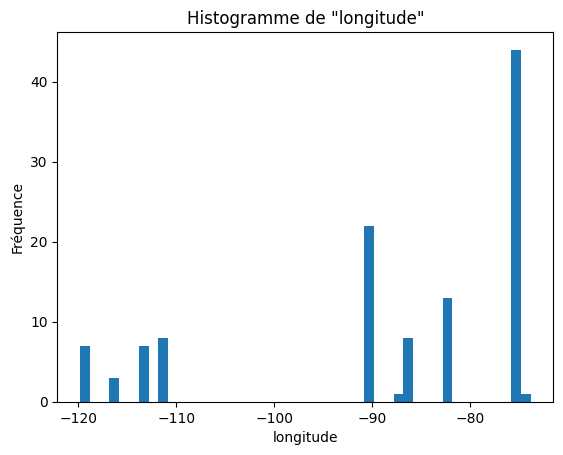

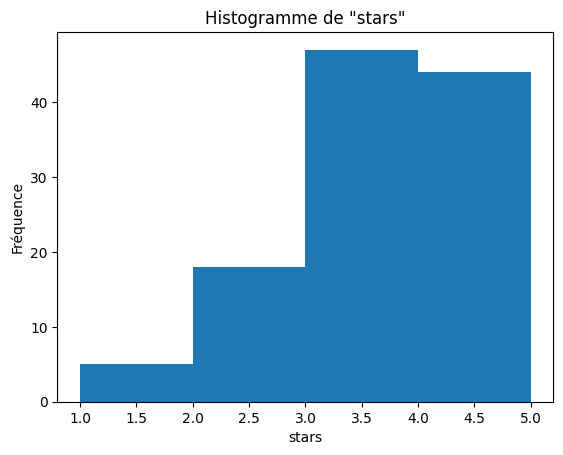

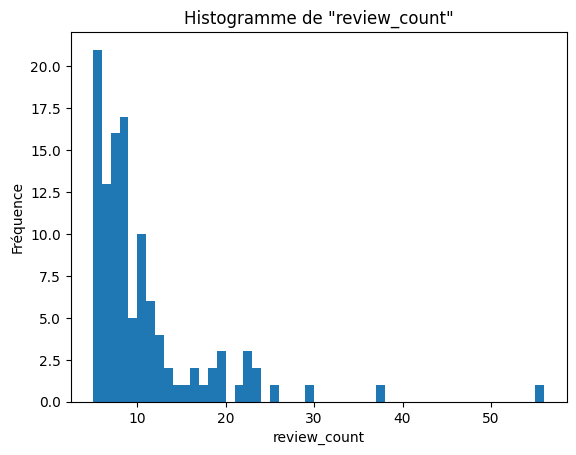

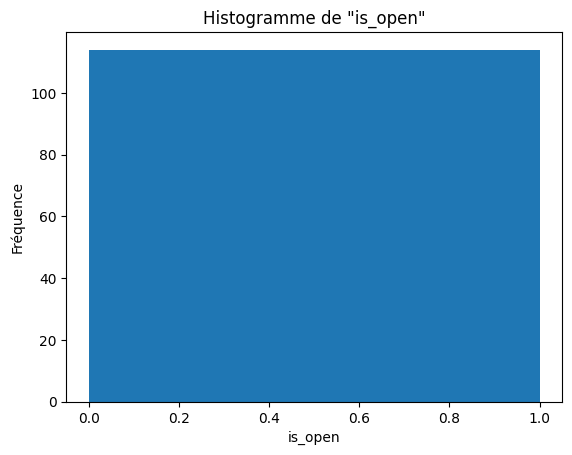

In [11]:
import numpy as np
import matplotlib.pyplot as plt

for col in df_restaurants_num.columns:
  plt.figure()
  plt.hist(df_restaurants_num[col], bins=np.arange(num_attr_ranges[col][0], num_attr_ranges[col][1] + 1))
  plt.title(f'Histogramme de "{col}"')
  plt.xlabel(col)
  plt.ylabel('Fréquence')
  plt.show()


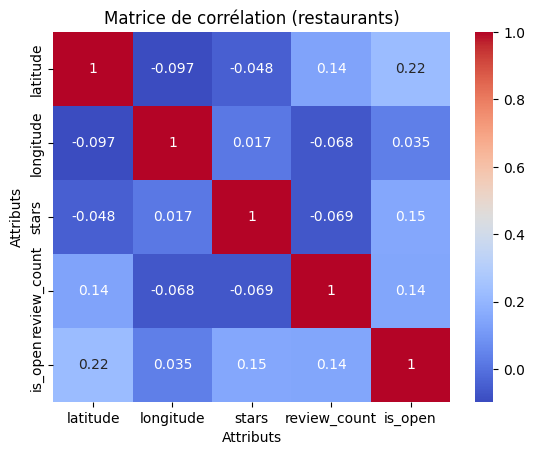

In [12]:
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = df_restaurants_num.corr()

# Create a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Set the title and labels
plt.title('Matrice de corrélation (restaurants)')
plt.xlabel('Attributs')
plt.ylabel('Attributs')

# Display the plot
plt.show()


In [13]:
import matplotlib.pyplot as plt
import numpy as np
# Extract numerical attributes from 'df_users'
df_users_num = df_users.select_dtypes(include=np.number)

# Get the range of values for each numerical attribute
num_attr_ranges = {}
for col in df_users_num.columns:
  num_attr_ranges[col] = (df_users_num[col].min(), df_users_num[col].max())

print(num_attr_ranges)

# # Create pairplots for numerical attributes
# sns.pairplot(df_users_num)



{'review_count': (1, 5511), 'useful': (0, 28235), 'funny': (0, 12978), 'cool': (0, 18687), 'fans': (0, 1357), 'average_stars': (1.0, 5.0), 'compliment_hot': (0, 3703), 'compliment_more': (0, 276), 'compliment_profile': (0, 359), 'compliment_cute': (0, 412), 'compliment_list': (0, 239), 'compliment_note': (0, 2406), 'compliment_plain': (0, 8807), 'compliment_cool': (0, 4983), 'compliment_funny': (0, 4983), 'compliment_writer': (0, 815), 'compliment_photos': (0, 1437)}


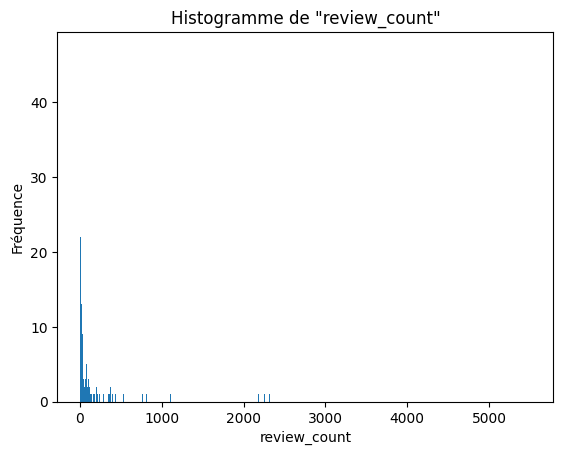

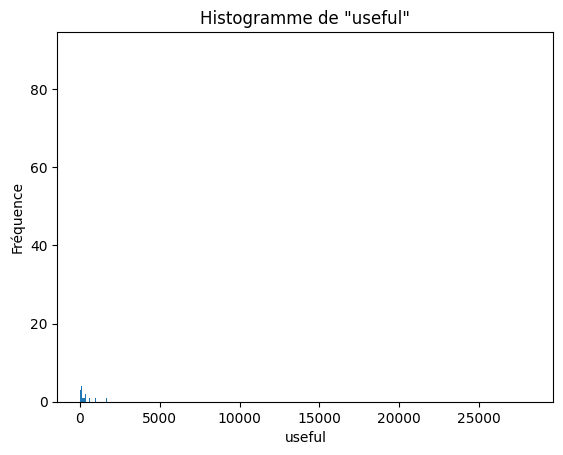

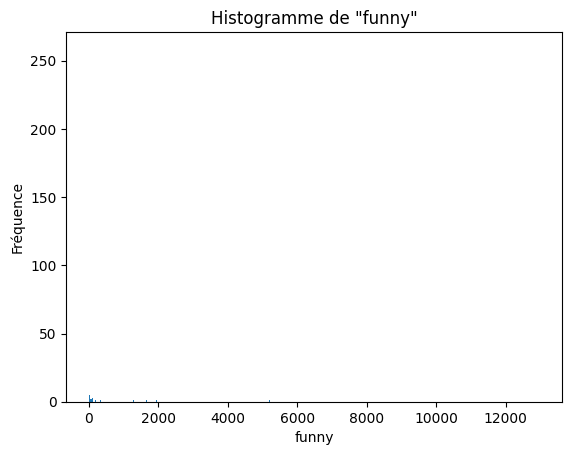

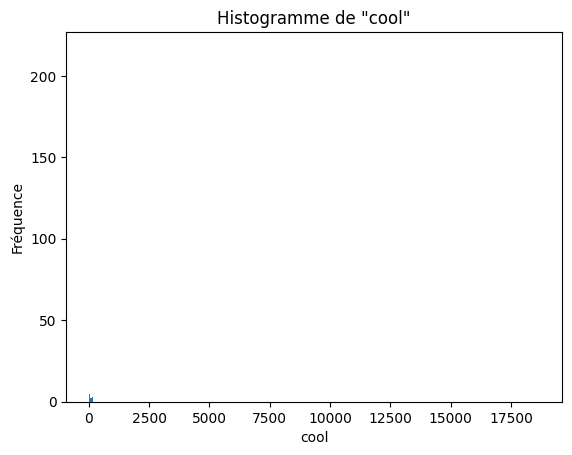

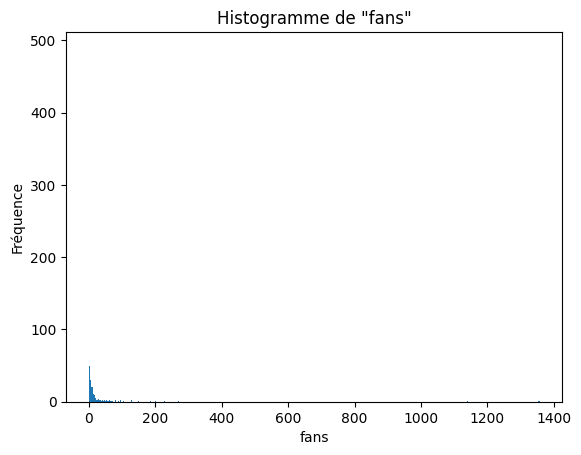

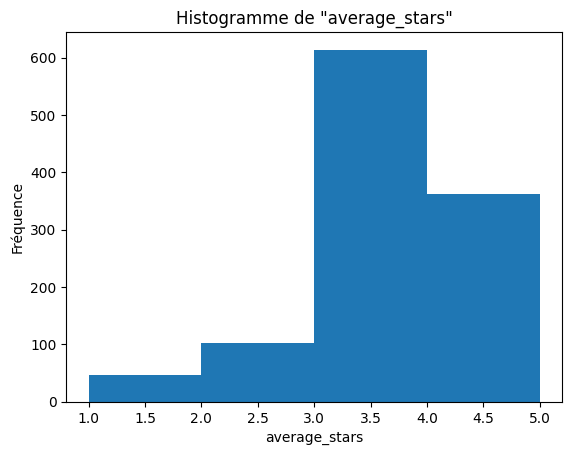

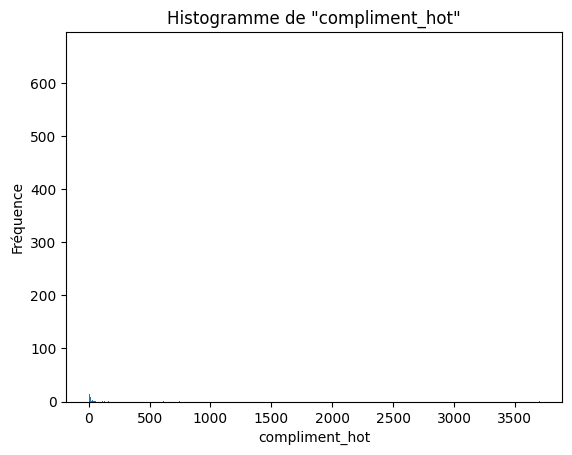

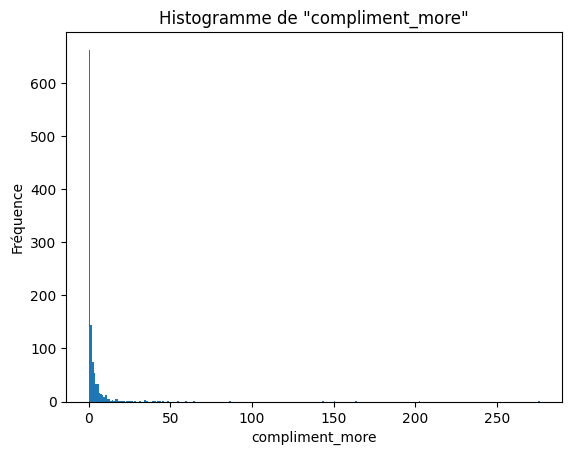

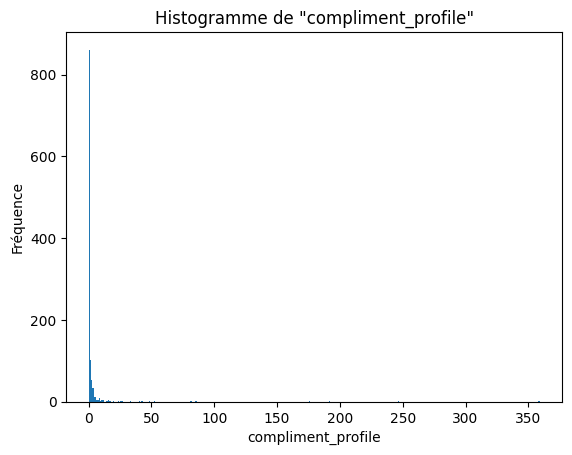

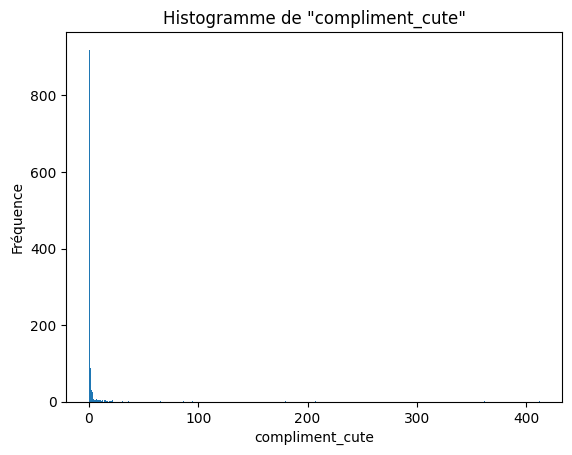

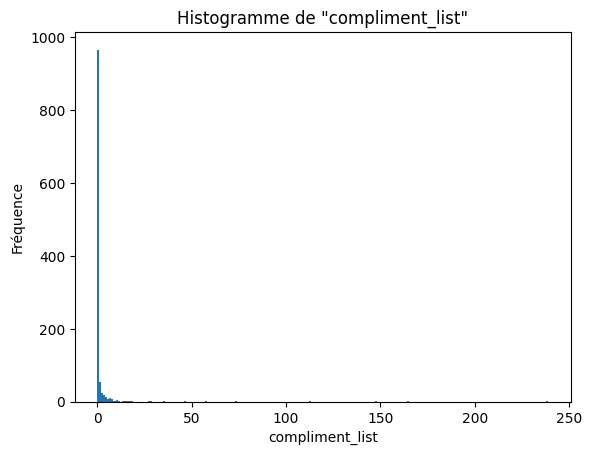

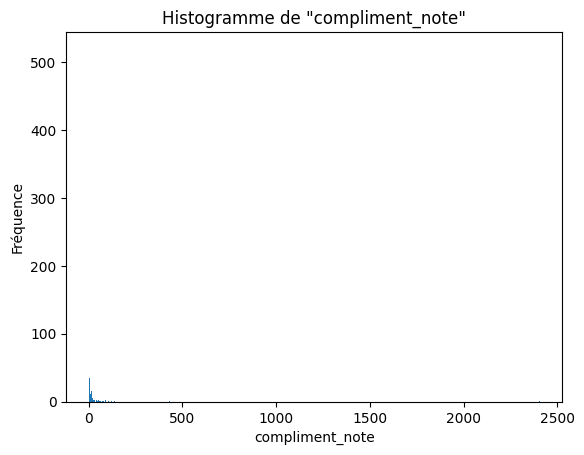

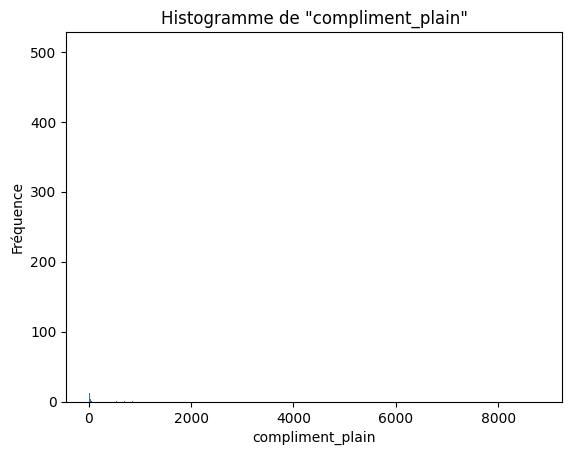

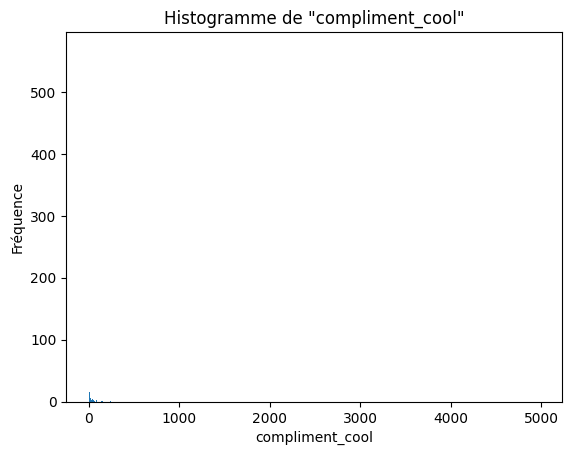

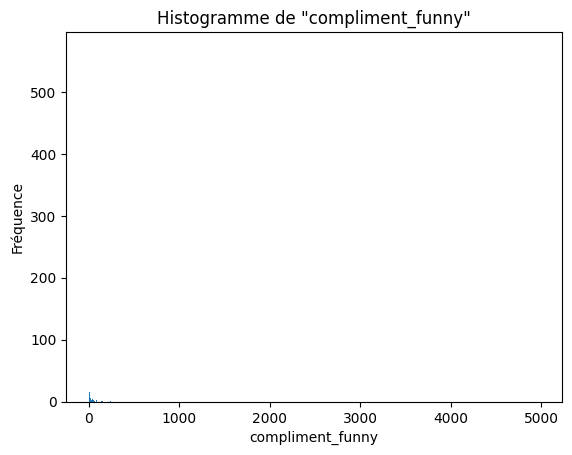

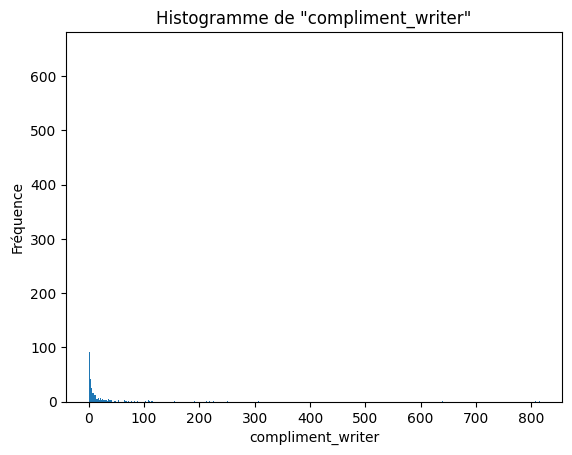

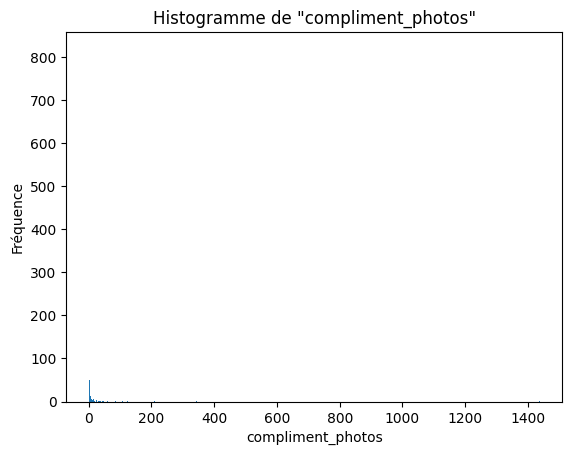

In [14]:

# Create histograms for each numerical attribute
for col in df_users_num.columns:
  plt.figure()
  plt.hist(df_users_num[col], bins=np.arange(num_attr_ranges[col][0], num_attr_ranges[col][1] + 1))
  plt.title(f'Histogramme de "{col}"')
  plt.xlabel(col)
  plt.ylabel('Fréquence')
  plt.show()


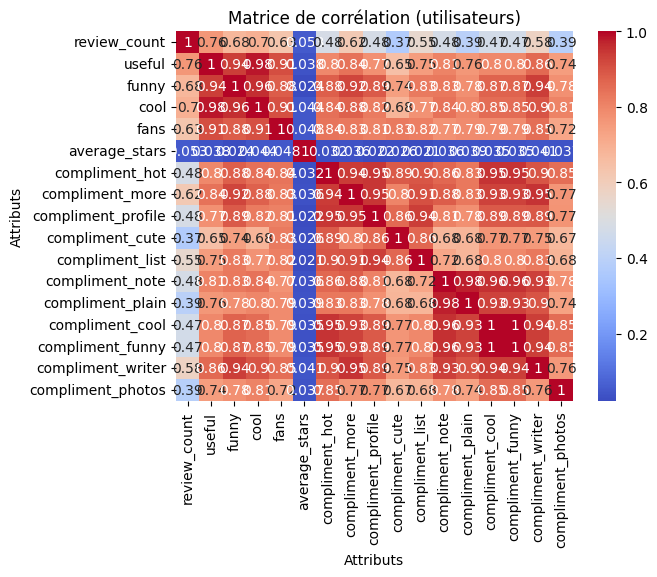

In [15]:

# Compute the correlation matrix
corr_matrix = df_users_num.corr()

# Create a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Set the title and labels
plt.title('Matrice de corrélation (utilisateurs)')
plt.xlabel('Attributs')
plt.ylabel('Attributs')

# Display the plot
plt.show()

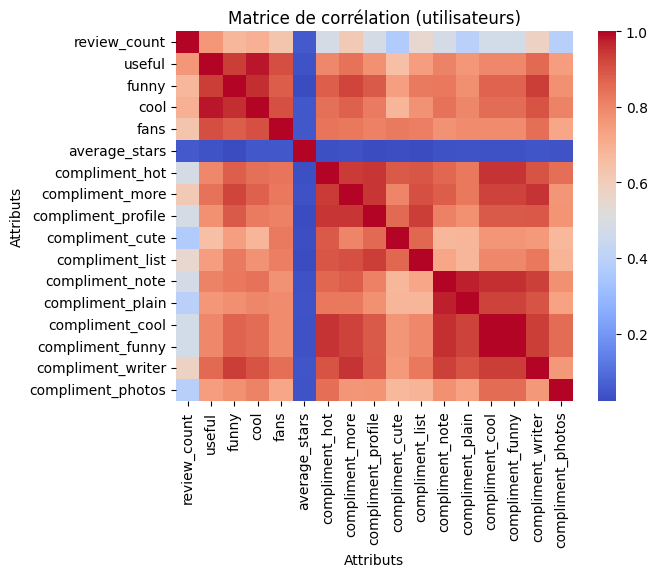

In [16]:
import matplotlib.pyplot as plt
# Compute the correlation matrix
corr_matrix = df_users_num.corr()

# Create a heatmap without labels
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')

# Set the title and labels
plt.title('Matrice de corrélation (utilisateurs)')
plt.xlabel('Attributs')
plt.ylabel('Attributs')

# Display the plot
plt.show()


In [17]:
review_restaurants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202 entries, 0 to 1201
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   review_id    1202 non-null   object 
 1   user_id      1202 non-null   object 
 2   business_id  1202 non-null   object 
 3   stars        1202 non-null   int64  
 4   useful       1202 non-null   int64  
 5   funny        1202 non-null   int64  
 6   cool         1202 non-null   int64  
 7   text         1202 non-null   object 
 8   date         1202 non-null   object 
 9   POSITIVE     1202 non-null   float64
 10  NEGATIVE     1202 non-null   float64
dtypes: float64(2), int64(4), object(5)
memory usage: 103.4+ KB


<a id="ref3"></a>
<h2>The Restricted Boltzmann Machine model</h2>

<img src="https://i.imgur.com/tdFk1NH.png"  width="300">
<br>
The Restricted Boltzmann Machine model has two layers of neurons, one of which is what we call a visible input layer and the other is called a hidden layer. The hidden layer is used to learn features from the information fed through the input layer. For our model, the input is going to contain X neurons, where X is the amount of restaurants in our dataset. Each of these neurons will possess a normalized rating value varying from 0 to 1, where 0 meaning that a user has not gone to that restaurant and the closer the value is to 1, the more the user likes the restaurant that neuron's representing. These normalized values, of course, will be extracted and normalized from the ratings dataset, specifically the number of stars given to restaurants.

After passing in the input, we train the RBM on it and have the hidden layer learn its features. These features are what we use to reconstruct the input, which in our case, will predict the ratings for restaurant that a given user hasn't gone to.

We will now begin to format our dataset to follow the model's expected input.

In [18]:

# Merge DataFrames
combined_df = review_restaurants.merge(df_restaurants, on='business_id')
combined_df = combined_df.merge(df_users, on='user_id')


In [19]:
combined_df.columns

Index(['review_id', 'user_id', 'business_id', 'stars_x', 'useful_x', 'funny_x',
       'cool_x', 'text', 'date', 'POSITIVE', 'NEGATIVE', 'name_x', 'address',
       'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars_y',
       'review_count_x', 'is_open', 'attributes', 'categories', 'hours',
       'name_y', 'review_count_y', 'yelping_since', 'useful_y', 'funny_y',
       'cool_y', 'elite', 'friends', 'fans', 'average_stars', 'compliment_hot',
       'compliment_more', 'compliment_profile', 'compliment_cute',
       'compliment_list', 'compliment_note', 'compliment_plain',
       'compliment_cool', 'compliment_funny', 'compliment_writer',
       'compliment_photos'],
      dtype='object')

In [20]:
combined_df_agg = combined_df.groupby('user_id').agg({'stars_x': 'mean', 'review_id': 'count'})
combined_df_agg.rename(columns={'review_id': 'review_count'}, inplace=True)


In [21]:
combined_df_agg

,stars_x,review_count
user_id,,
--KsuCSkGGvDKTbdK9NvIg,3.0,1
-63BhPqs8Uf3YrXFo9jskg,5.0,1
-B-QEUESGWHPE_889WJaeg,2.0,1
-GDdBOfhrxn7lAGblLSoqA,4.0,1
-IJ70Lh1NZ0uXC66xM-tGA,3.0,1
...,...,...
zj10N7YjZlgkVYup4xXwiQ,1.0,1
zkch2QUSC7zappMvdTvV0g,4.0,1
zrdkuuPFlNkLTSa9gMqbvQ,2.0,1


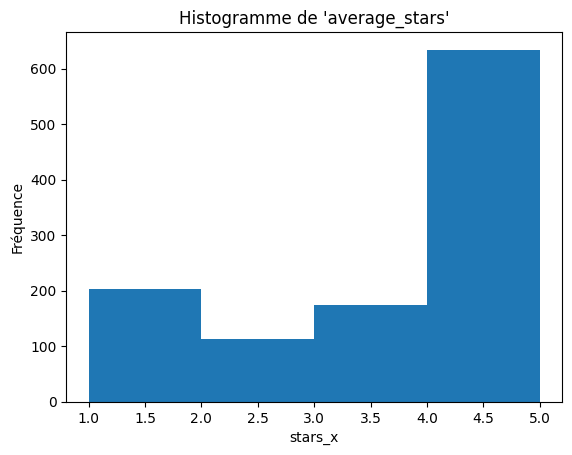

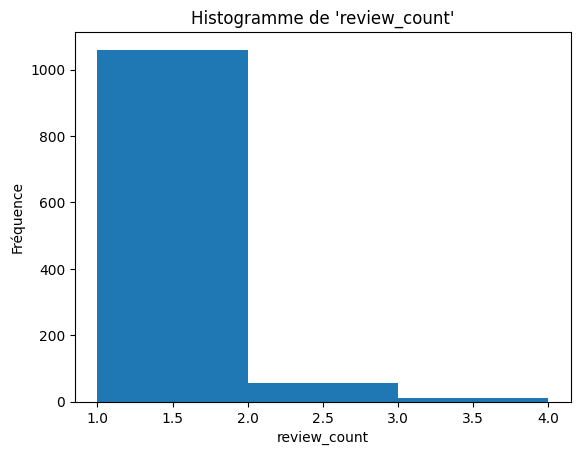

In [22]:
import matplotlib.pyplot as plt
import numpy as np
# Create histograms for each numerical attribute
for col in combined_df_agg.columns:
  plt.figure()
  plt.hist(combined_df_agg[col], bins=np.arange(combined_df_agg[col].min(), combined_df_agg[col].max() + 1))
  plt.title(f"""Histogramme de '{col if (col!="stars_x") else 'average_stars'}'""")
  plt.xlabel(col)
  plt.ylabel('Fréquence')
  plt.show()


In [23]:
user_rating_df = combined_df.pivot_table(values='stars_x', index='user_id', columns='business_id')

In [24]:
user_rating_df.head()

business_id,-PkchovDBosOtZx4XLatVw,-SGvS9V0Yc5Ler2HrgtYJw,0CennNWmhiYdSOEkGr7vkw,2INVBDZ45z4Tbg3VtdDyTg,2lzcB7p5YlBimh4vfr6Fpw,2s5h1TMhYPdRUUNcQFr3WA,3tTVN74KJAN0z1DJ_dsE6w,4IvQU16RBKuLtpgx8yLqmQ,4qie_VdA-vTitNFl36F9Pw,7IoEVMWgTFjjaYG02eQAsw,...,vb9VqzcTk3pUWuyWwTV0tg,vw-xE1CJ9fYRSPu9Iy9mdA,wEWy_NbtwcgNY2dKEmnACA,x2J-YIFeGZ-nsezzooVA9g,x2xQUz1YfOzy5A9FRuCpMw,xEoAXOgrUOh-M1NUp6-Kaw,yHtS6dj20tl3ht32w6K6Qw,yOAZ47U67aDUwDXMrnv8UQ,yezrPF5W9KBm-JI9ZeudNg,yhx1hIne1Wr-9v4EMdziRw
user_id,,,,,,,,,,,,,,,,,,,,,
--KsuCSkGGvDKTbdK9NvIg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-63BhPqs8Uf3YrXFo9jskg,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-B-QEUESGWHPE_889WJaeg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-GDdBOfhrxn7lAGblLSoqA,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-IJ70Lh1NZ0uXC66xM-tGA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
user_rating_df.fillna(0, inplace=True)
norm_user_rating_df = user_rating_df.fillna(0) / 5.0
trX = norm_user_rating_df.values
trX[0:5]

array([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0.6, 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.

In [26]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<a id="ref4"></a>
<h2>Setting the Model's Parameters</h2>

Next, let's start building our RBM with TensorFlow. We'll begin by first determining the number of neurons in the hidden layers and then creating placeholder variables for storing our visible layer biases, hidden layer biases and weights that connects the hidden layer with the visible layer. We will be arbitrarily setting the number of neurons in the hidden layers to experiment.

In [27]:
hidden_units = 100
visible_units = len(user_rating_df.columns)
vb = tf.Variable(tf.zeros([visible_units]), dtype=tf.float32)
hb = tf.Variable(tf.zeros([hidden_units]), dtype=tf.float32)
W = tf.Variable(tf.random.normal([visible_units, hidden_units]), dtype=tf.float32)

We then move on to creating the visible and hidden layer units and setting their activation functions. In this case, we will be using the <code>tf.sigmoid</code> and <code>tf.relu</code> functions as nonlinear activations since it is commonly used in RBM's.

In [28]:
# Phase 1: Input Processing
v0 = tf.Variable(tf.zeros([tf.shape(trX)[0], visible_units]), dtype=tf.float32)
_h0 = tf.keras.activations.sigmoid(tf.matmul(v0, W) + hb)
h0 = tf.keras.activations.relu(tf.sign(_h0 - tf.random.uniform(tf.shape(_h0))))

#Phase 2: Reconstruction
_v1 = tf.keras.activations.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb)
v1 = tf.keras.activations.relu(tf.sign(_v1 - tf.random.uniform(tf.shape(_v1))))
h1 = tf.keras.activations.sigmoid(tf.matmul(v1, W) + hb)

Now we set the RBM training parameters and functions.

In [29]:
# Learning rate
alpha = 1e-4




And set the error function, which in this case will be the Mean Absolute Error Function.

In [30]:
# Error calculation
err = v0 - v1
err_sum = tf.reduce_mean(err * err)

Now we train the RBM with 15 epochs with each epoch using 10 batches with size 100. After training, we print out a graph with the error by epoch.

Epoch 1: Error = 0.4779649078845978
Epoch 2: Error = 0.4779649078845978
Epoch 3: Error = 0.4779649078845978
Epoch 4: Error = 0.4779649078845978
Epoch 5: Error = 0.4779649078845978
Epoch 6: Error = 0.4779649078845978
Epoch 7: Error = 0.4779649078845978
Epoch 8: Error = 0.4779649078845978
Epoch 9: Error = 0.4779649078845978
Epoch 10: Error = 0.4779649078845978


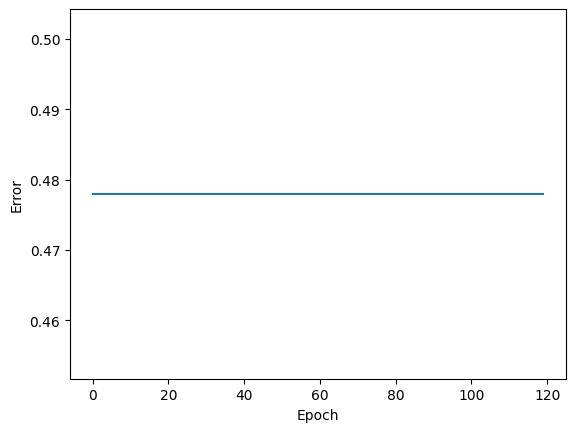

In [31]:
# Training loop
epochs = 10
batch_size = 100
errors = []
for epoch in range(epochs):
    for start in range(0, len(trX), batch_size):
        end = min(start + batch_size, len(trX))
        batch = trX[start:end]

        # Contrastive Divergence
        w_pos_grad = tf.matmul(tf.transpose(v0), h0)
        w_neg_grad = tf.matmul(tf.transpose(v1), h1)
        CD = (w_pos_grad - w_neg_grad) / tf.cast(tf.shape(v0)[0], tf.float32)

        # Update rules
        update_w = W + alpha * CD
        update_vb = vb + alpha * tf.reduce_mean(v0 - v1, axis=0)
        update_hb = hb + alpha * tf.reduce_mean(h0 - h1, axis=0)

        # Update weights and biases using eager execution
        W.assign(update_w)
        vb.assign(update_vb)
        hb.assign(update_hb)


        errors.append(err_sum.numpy())

    print(f"Epoch {epoch+1}: Error = {errors[-1]}")

# Plot errors
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

In [32]:
import matplotlib.pyplot as plt
# Training loop


Epoch 1: Error = 0.4685754179954529
Epoch 2: Error = 0.45271578431129456
Epoch 3: Error = 0.46534737944602966
Epoch 4: Error = 0.4526456296443939
Epoch 5: Error = 0.4635929763317108
Epoch 6: Error = 0.46043509244918823
Epoch 7: Error = 0.4405052363872528
Epoch 8: Error = 0.44541752338409424
Epoch 9: Error = 0.4562947154045105
Epoch 10: Error = 0.45208418369293213
Epoch 11: Error = 0.44625967741012573
Epoch 12: Error = 0.46927717328071594
Epoch 13: Error = 0.45404914021492004
Epoch 14: Error = 0.43924209475517273
Epoch 15: Error = 0.4504702091217041
Epoch 16: Error = 0.4522245526313782
Epoch 17: Error = 0.4552420973777771
Epoch 18: Error = 0.45678600668907166
Epoch 19: Error = 0.4499087631702423
Epoch 20: Error = 0.43152284622192383
Epoch 21: Error = 0.44731226563453674
Epoch 22: Error = 0.453908771276474
Epoch 23: Error = 0.44190874695777893
Epoch 24: Error = 0.42640000581741333
Epoch 25: Error = 0.45622456073760986
Epoch 26: Error = 0.43285614252090454
Epoch 27: Error = 0.442610502243

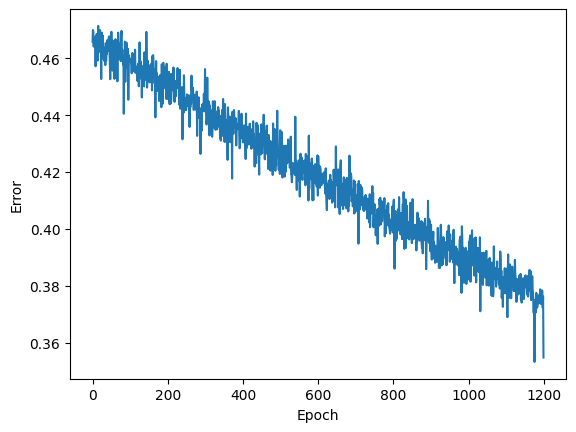

In [33]:
epochs = 100
batch_size = 100
errors = []
for epoch in range(epochs):
    for start in range(0, len(trX), batch_size):
        end = min(start + batch_size, len(trX))
        batch = trX[start:end]

        v0 = tf.Variable(batch, dtype=tf.float32)
        _h0 = tf.keras.activations.sigmoid(tf.matmul(v0, W) + hb)
        h0 = tf.keras.activations.relu(tf.sign(_h0 - tf.random.uniform(tf.shape(_h0))))
        #Phase 2: Reconstruction
        _v1 = tf.keras.activations.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb)
        v1 = tf.keras.activations.relu(tf.sign(_v1 - tf.random.uniform(tf.shape(_v1))))
        h1 = tf.keras.activations.sigmoid(tf.matmul(v1, W) + hb)

        # Learning rate
        alpha = 1e-4

        # MSE calculation
        err = v0 - v1
        err_sum = tf.reduce_mean(err * err)


        w_pos_grad = tf.matmul(tf.transpose(v0), h0)
        w_neg_grad = tf.matmul(tf.transpose(v1), h1)
        CD = (w_pos_grad - w_neg_grad) / tf.cast(tf.shape(v0)[0], tf.float32)

        # Update rules
        update_w = W + alpha * CD
        update_vb = vb + alpha * tf.reduce_mean(v0 - v1, axis=0)
        update_hb = hb + alpha * tf.reduce_mean(h0 - h1, axis=0)

        # Update weights and biases eagerly
        W.assign(update_w)
        vb.assign(update_vb)
        hb.assign(update_hb)

        errors.append(err_sum.numpy())

    print(f"Epoch {epoch+1}: Error = {errors[-1]}")

# Plot errors
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()


Epoch 100: Error = 0.4139942526817322


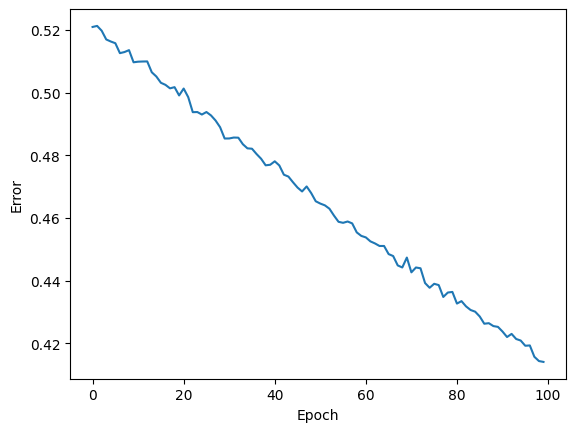

In [97]:
import matplotlib.pyplot as plt
from statistics import mean

class RBM:
    def __init__(self, num_visible, num_hidden):
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.W = tf.Variable(tf.random.normal([num_visible, num_hidden]), dtype=tf.float32)
        self.vb = tf.Variable(tf.zeros([num_visible]), dtype=tf.float32)
        self.hb = tf.Variable(tf.zeros([num_hidden]), dtype=tf.float32)

    def propup(self, v0):
        _h0 = tf.keras.activations.sigmoid(tf.matmul(v0, self.W) + self.hb)
        h0 = tf.keras.activations.relu(tf.sign(_h0 - tf.random.uniform(tf.shape(_h0))))
        return h0

    def propdown(self, h0):
        _v1 = tf.keras.activations.sigmoid(tf.matmul(h0, tf.transpose(self.W)) + self.vb)
        v1 = tf.keras.activations.relu(tf.sign(_v1 - tf.random.uniform(tf.shape(_v1))))
        return v1

    def contrastive_divergence(self, v0):
        h0 = self.propup(v0)
        v1 = self.propdown(h0)
        h1 = self.propup(v1)
        return v0, v1, h0, h1

    def calculate_fid(self, X, num_batches=10):
        # Generate samples from the RBM
        samples = []
        for _ in range(num_batches):
            v0 = tf.Variable(tf.zeros([100, self.num_visible]), dtype=tf.float32)
            samples.append(self.propdown(self.propup(v0)).numpy())

        # Concatenate the samples
        samples = np.concatenate(samples, axis=0)

        # Calculate the mean and covariance of the samples
        mu_samples = np.mean(samples, axis=0)
        cov_samples = np.cov(samples.T)

        # Calculate the mean and covariance of the real data
        mu_real = np.mean(X, axis=0)
        cov_real = np.cov(X.T)

        # Calculate the FID
        fid = np.linalg.norm(mu_samples - mu_real) ** 2 + np.trace(cov_samples + cov_real - 2 * np.sqrt(np.matmul(cov_samples, cov_real)))

        return fid

    def train(self, X, epochs, batch_size, alpha):
        errors = []
        for epoch in range(epochs):
            errors_batch = []
            for start in range(0, len(X), batch_size):
                end = min(start + batch_size, len(X))
                batch = X[start:end]

                v0 = tf.Variable(batch, dtype=tf.float32)
                v0, v1, h0, h1 = self.contrastive_divergence(v0)

                w_pos_grad = tf.matmul(tf.transpose(v0), h0)
                w_neg_grad = tf.matmul(tf.transpose(v1), h1)
                CD = (w_pos_grad - w_neg_grad) / tf.cast(tf.shape(v0)[0], tf.float32)

                update_w = self.W + alpha * CD
                update_vb = self.vb + alpha * tf.reduce_mean(v0 - v1, axis=0)
                update_hb = self.hb + alpha * tf.reduce_mean(h0 - h1, axis=0)

                self.W.assign(update_w)
                self.vb.assign(update_vb)
                self.hb.assign(update_hb)

                err = v0 - v1
                err_sum = tf.reduce_mean(err * err)
                errors_batch.append(err_sum.numpy())

            errors.append(mean(errors_batch))

        print(f"Epoch {epoch+1}: Error = {errors[-1]}")

        return errors

# Example training session
rbm = RBM(num_visible=len(user_rating_df.columns), num_hidden=100)
errors = rbm.train(X=trX, epochs=100, batch_size=100, alpha=1e-4)

# Plot errors
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()


In [95]:
import numpy as np
from sklearn.model_selection import KFold

# Define the parameter grid
param_grid = {
    'num_hidden': [50, 100, 200],
    'alpha': [1e-3, 1e-4, 1e-5]
}

# Create a KFold object for cross-validation
kf = KFold(n_splits=5)

# Initialize lists to store the best parameters and errors
best_params = []
best_errors = []

# Iterate over the parameter grid
for num_hidden in param_grid['num_hidden']:
    for alpha in param_grid['alpha']:
        # Create an RBM instance with the current parameters
        rbm = RBM(num_visible=len(user_rating_df.columns), num_hidden=num_hidden)

        # Perform cross-validation
        errors = []
        for train_idx, test_idx in kf.split(trX):
            X_train, X_test = trX[train_idx], trX[test_idx]

            # Train the RBM on the training set
            rbm.train(X=X_train, epochs=100, batch_size=100, alpha=alpha)

            # Evaluate the RBM on the test set
            v0 = tf.Variable(X_test, dtype=tf.float32)
            v1 = rbm.propdown(rbm.propup(v0))
            err = v0 - v1
            err_sum = tf.reduce_mean(err * err)
            errors.append(err_sum.numpy())

        # Calculate the average error for the current parameters
        avg_error = np.mean(errors)

        # Store the best parameters and errors
        best_params.append({'num_hidden': num_hidden, 'alpha': alpha})
        best_errors.append(avg_error)

# Find the parameters that resulted in the lowest average error
best_idx = np.argmin(best_errors)
best_params = best_params[best_idx]

# Print the best parameters and error
print(f"Best Parameters: {best_params}")
print(f"Best Error: {best_errors[best_idx]}")


Epoch 100: Error = 0.20619826018810272
Epoch 100: Error = 0.11096102744340897
Epoch 100: Error = 0.06770677119493484
Epoch 100: Error = 0.04567894712090492
Epoch 100: Error = 0.03297967463731766
Epoch 100: Error = 0.45089027285575867
Epoch 100: Error = 0.3978830575942993
Epoch 100: Error = 0.3586021661758423
Epoch 100: Error = 0.32522085309028625
Epoch 100: Error = 0.2957249581813812
Epoch 100: Error = 0.4684107303619385
Epoch 100: Error = 0.4609980881214142
Epoch 100: Error = 0.4573078155517578
Epoch 100: Error = 0.45122280716896057
Epoch 100: Error = 0.44748130440711975
Epoch 100: Error = 0.14355693757534027
Epoch 100: Error = 0.06935673952102661
Epoch 100: Error = 0.04042671620845795
Epoch 100: Error = 0.025636062026023865
Epoch 100: Error = 0.018225936219096184
Epoch 100: Error = 0.4749039113521576
Epoch 100: Error = 0.4041150212287903
Epoch 100: Error = 0.34440526366233826
Epoch 100: Error = 0.2979460060596466
Epoch 100: Error = 0.2603253722190857
Epoch 100: Error = 0.501072883605

Epoch 200: Error = 0.030160900205373764


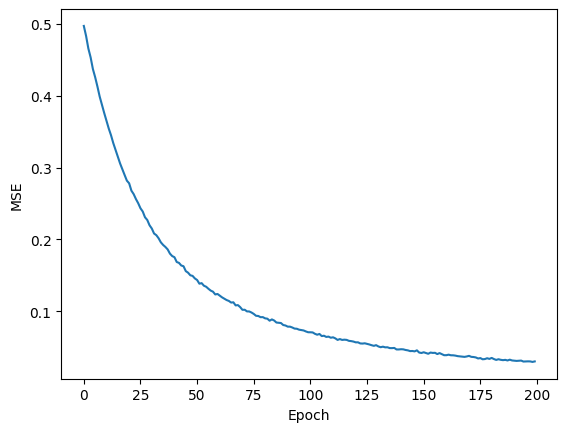

In [96]:
import matplotlib.pyplot as plt
# Train the RBM with the best parameters for 200 epochs
rbm = RBM(num_visible=len(user_rating_df.columns), num_hidden=best_params['num_hidden'])
errors = rbm.train(X=trX, epochs=200, batch_size=100, alpha=best_params['alpha'])

# Plot the MSE
plt.plot(errors)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.show()


In [35]:
# Max number of ratings per user
np.count_nonzero(trX, axis=1).max()

4

In [36]:
# Average number of ratings per user
np.count_nonzero(trX, axis=1).mean()

1.0373333333333334

In [37]:
from collections import Counter
unique_ratings_count = dict(Counter(np.count_nonzero(trX, axis=1)))
unique_ratings_count

{1: 1087, 2: 35, 3: 2, 4: 1}

The trX matrix of ratings is of shape (1125, 114) , so 1125 users rating 114 restaurants. Each user rated at most 4 restaurants and the average number of restaurants rated per user is barely above 1. In fact, an overwhelming majority of users rated only one restaurant.
The sparsity of the ratings matrix leads to an extremely sparse signal for the RBM, whose strength as a recommender model lies in the potential overlaps/similarities in user ratings across restaurants.  We conclude that a Restricted Boltzmann Machine might not be the right model in our case, since there is not enough "interactions" between users and restaurants

On the other hand:

In [38]:
dict(Counter(np.count_nonzero(trX.T, axis=1)))

{15: 1,
 56: 1,
 6: 13,
 8: 17,
 16: 2,
 13: 2,
 7: 16,
 12: 4,
 19: 3,
 23: 2,
 5: 21,
 25: 1,
 37: 1,
 9: 5,
 21: 1,
 10: 10,
 18: 2,
 11: 6,
 22: 3,
 17: 1,
 14: 1,
 29: 1}

### Training KNN-based algorithm to make use of user-user and restaurant-restaurant similarity

#### 1st approach: using user-based CF

In [39]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(trX)

NearestNeighbors(algorithm='brute', metric='cosine')

In [40]:
distances, _ = knn.kneighbors(trX)
average_neighbor_distance = distances.mean(axis=1).mean()
print("Average Nearest Neighbor Distance:", average_neighbor_distance)

Average Nearest Neighbor Distance: 0.007640062591319379


In [41]:
# Quick util to fill NaN
def fillna(arr):
    return np.where(np.isnan(arr), 0, arr)

arr = np.array([1, 2, np.NaN])
filled_arr = fillna(arr)
print(filled_arr)  # Output: [1 2 0]

[1. 2. 0.]


In [42]:
#Simple KNN-based recommendation

def similar_users_from_ratings(user_ratings, k=5, user_index=None):
    user_ratings = fillna(user_ratings)
    distances, indices = knn.kneighbors(user_ratings.reshape(1, -1), n_neighbors=k+1)
    nearest_neighbors = indices[0] if user_index==None else np.delete(indices[0], np.where(indices[0] == user_index))  # Exclude the user itself

    return user_rating_df.iloc[nearest_neighbors]

def similar_users_from_id(user_id, k=5):
    user_index = user_rating_df.index.get_loc(user_id)
    user_ratings = trX[user_index]
    return similar_users_from_ratings(user_ratings,k , user_index)


def recommend_restaurants_from_id_naive(user_id, n_sim=10):
  user_ids = similar_users_from_id(user_id, k=n_sim).idxmax(axis=1)
  return df_restaurants.loc[df_restaurants['business_id'].isin(user_ids)]

def recommend_restaurants_from_ratings_naive(user_ratings, n_sim=10):
  restaurants_ids=similar_users_from_ratings(user_ratings, k=n_sim).idxmax(axis=1)
  return df_restaurants.loc[df_restaurants['business_id'].isin(restaurants_ids)]


##### Example use

In [43]:
user_to_recommend = df_users.iloc[0]['user_id']
df_users.loc[df_users['user_id'].isin(similar_users_from_id(user_to_recommend, k=10).index.values)]

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
52,BI4lPhrUpmEySIJUywjIjQ,Dee,1592,2005-07-08 15:21:37,2975,736,1460,"2006,2007,2008,2009,2010,2011,2012,2013","yApfpuLJmEYcXt_lpz_e8w, 4uqrXK9mECd6HsaSAV8_yA...",160,...,17,8,65,46,155,212,208,208,41,47
117,qunxFdBDVl0ordRJEPVNtQ,Lemonjelly,429,2007-04-06 21:36:06,1901,1317,1304,NaN,"NIgHMvhoSsP2nVT-AqVWNg, 5t8ySlAmpQS8P-xFYOu8Aw...",128,...,31,3,5,27,79,100,103,103,115,55
161,8Lc3-TTHjExd79GSQIHnAw,Christopher,627,2006-12-19 07:07:26,615,257,283,NaN,"uqY0yL_zKk-4CcOdEDJ-Ow, 3imjJmcsBveqpSdyTUY5UQ...",31,...,4,8,5,6,24,19,37,37,12,2
557,cs1GMqTt5eGmLqQyPijYcw,Jen,162,2006-06-15 23:14:05,268,214,147,"2006,2007","4ohEUObG716U9GNlMK7eNg, L2g6vS1GDfqLEpiDOFfCkA...",15,...,3,2,14,0,9,10,18,18,3,7
685,PSNakuyRt9i2TS1fz3pp_w,Angela,253,2007-10-09 16:34:18,252,64,70,"2009,2010","fvHiupqwrjwZ9GL8da6xtA, UVxY0iyPaqY7s4BSFtt-xA...",8,...,1,0,0,0,6,7,11,11,6,2
688,XJ5WJPLP-fTIFkza3ChGbA,Robbie,46,2007-04-03 15:06:24,35,18,22,NaN,"8hG50IvPBPpwVGA5HiZkHg, MGIfvuAcgbUtRnhWa_Jm2g...",4,...,0,0,0,0,1,4,4,4,0,0
929,WBmqTb2IrJu9_nIWgZu21g,Catherine,216,2006-02-20 20:43:59,378,101,207,"2006,2007,2008","huowshdRZBhpYV_7mCRM3Q, NZba-Q-Fp10iF77CTQt24Q...",23,...,4,4,3,0,14,27,31,31,10,2
932,WJnEifJRkI6bCH2iw8brFg,Nenette,576,2006-02-07 05:13:06,860,264,478,"2006,2007,2008,2009","umIYHRbXtyb_Yy5uThSD_A, wRGdmKC5Du-lxo01T06Fxg...",39,...,3,1,3,0,9,15,34,34,15,2
1045,J5aAT9bz6KQwfqosRuTt9w,Rebecca,108,2007-07-10 00:06:09,84,24,58,NaN,"57EebK4ybrj9uO3eBq1I3Q, xKD6xH0ga9KsMXDIwz2MCw...",2,...,1,0,1,0,3,5,8,8,4,2
1110,sugA1tq1RD1hflVQZvesIg,Enrique,500,2008-04-23 23:04:19,777,352,466,"2010,2011,2012,2013,2014,2015,2016,2017","Wx7cbLDqYEL3_aVZwh82Ww, mgE3Em0bbFewVaMrADoEHw...",50,...,7,6,0,1,20,53,64,64,37,5


In [44]:
recommend_restaurants_from_id_naive(user_to_recommend)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
109,QNoFrASBpqW8dzdAEIYjNQ,The Brown Pelican,2981 Cliff Dr,Santa Barbara,CA,93109,34.403821,-119.743656,4.0,11,0,"{'BusinessParking': ""{'garage': False, 'street...",Restaurants,NaN


##### Extending recommendations beyond best rated restaurant

In [45]:
import itertools

def flatten_n_times(data, n=1):
  if n == 0:
    return data
  result = []
  for item in data:
    if isinstance(item, list):
      result.extend(flatten_n_times(item, n - 1))
    else:
      result.append(item)
  return list(set(itertools.chain.from_iterable(result)))


def get_top_n_columns_list(df, n, column_labels='restaurants'):

  # Create a new DataFrame with a single column
  top_n_df = pd.DataFrame(columns=["Top " + str(n) + " " + column_labels])

  # Iterate through each row in the DataFrame
  for index, row in df.iterrows():
    # Sort the row in descending order based on its values
    sorted_row = row.sort_values(ascending=False)

    # Select the top n column names
    top_n_columns = sorted_row.index[:n].tolist()

    # Add the top n column names to the new DataFrame
    top_n_df.loc[index, "Top " + str(n) + " " + column_labels] = top_n_columns

  return top_n_df

def recommend_restaurants_from_id_top(user_id, n_sim=10, top_n=5):
  top_restaurants = flatten_n_times(get_top_n_columns_list(similar_users_from_id(user_id, k=n_sim), top_n).values.tolist())
  return df_restaurants.loc[df_restaurants['business_id'].isin(top_restaurants)]

def recommend_restaurants_from_ratings_top(user_ratings, n_sim=10, top_n=5):
  top_restaurants = flatten_n_times(get_top_n_columns_list(similar_users_from_ratings(user_ratings, k=n_sim), top_n).values.tolist())
  return df_restaurants.loc[df_restaurants['business_id'].isin(top_restaurants)]


In [46]:
recommend_restaurants_from_id_top(user_to_recommend)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
17,yHtS6dj20tl3ht32w6K6Qw,Stateside Restaurant & Lounge,1114 State St,Santa Barbara,CA,93190,34.423044,-119.703208,2.5,10,0,"{'BusinessParking': ""{'garage': False, 'street...",Restaurants,NaN
33,iLT6EshGvA9yMdLTqeIE_Q,Michael's Diner Restaurant,719 S Broadway,Pennsville,NJ,08070,39.611270,-75.501917,2.5,5,0,"{'Ambience': ""{'romantic': False, 'intimate': ...",Restaurants,"{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ..."
61,j9YvgjesIwLMCBGqDw4TUQ,Iguana Cafe,210 E Congress St,Tucson,AZ,85701,32.221883,-110.968308,3.0,13,1,"{'RestaurantsPriceRange2': '1', 'BusinessAccep...",Restaurants,NaN
86,-PkchovDBosOtZx4XLatVw,Naceville Hotel,2038 Ridge Rd,Sellersville,PA,18960,40.351699,-75.372119,3.5,15,1,"{'Alcohol': ""u'full_bar'"", 'RestaurantsReserva...",Restaurants,NaN
103,eMAe0izoSWFxq8YIlpUREw,Coyote Crossing,102 Market Street,West Chester,PA,19382,39.960235,-75.603190,3.5,5,0,"{'RestaurantsPriceRange2': '3', 'RestaurantsRe...",Restaurants,NaN
107,i1pGM3unRHXWLr15yyeL9Q,Astral Plane,1708 Lombard Street,Philadelphia,PA,19146,39.945161,-75.170498,4.0,9,0,"{'RestaurantsGoodForGroups': 'True', 'Restaura...",Restaurants,NaN
109,QNoFrASBpqW8dzdAEIYjNQ,The Brown Pelican,2981 Cliff Dr,Santa Barbara,CA,93109,34.403821,-119.743656,4.0,11,0,"{'BusinessParking': ""{'garage': False, 'street...",Restaurants,NaN


#### 2nd approach: item-based CF

The approach is very similar to what we did in the previous chapter, except here we'll train the knn on the transpose of the ratings matrix


In [47]:
restaurant_rating_df = user_rating_df.T
restaurant_rating_df

user_id,--KsuCSkGGvDKTbdK9NvIg,-63BhPqs8Uf3YrXFo9jskg,-B-QEUESGWHPE_889WJaeg,-GDdBOfhrxn7lAGblLSoqA,-IJ70Lh1NZ0uXC66xM-tGA,-IoMd5brae24pyFRx13Phw,-J-ekA8rrhFV6jN5EvkLbg,-NDurCQ1u3CbUd05M7MaIA,-Oer2os7LrtAagVuWSN1AQ,-ZZ_ovaNT7EA1Fkokv44UQ,...,zOZR3F-fLi9oP5_PHFlqeQ,zUK5CQLSp_OVPpWDfeKAJQ,zUk_Ww2q1At1QSyRbUjIGQ,zflP2GbSos_x0vP_yCYZHg,zg23ChWAll3vAo5OGVRPyA,zj10N7YjZlgkVYup4xXwiQ,zkch2QUSC7zappMvdTvV0g,zrdkuuPFlNkLTSa9gMqbvQ,zux3SnpD2KSzYeCUlayGpw,zyNrXvJyYdC34tS6BcCykA
business_id,,,,,,,,,,,,,,,,,,,,,
-PkchovDBosOtZx4XLatVw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-SGvS9V0Yc5Ler2HrgtYJw,0.0,5.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0CennNWmhiYdSOEkGr7vkw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2INVBDZ45z4Tbg3VtdDyTg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2lzcB7p5YlBimh4vfr6Fpw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
xEoAXOgrUOh-M1NUp6-Kaw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yHtS6dj20tl3ht32w6K6Qw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yOAZ47U67aDUwDXMrnv8UQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
trY = trX.T
trY.shape

(114, 1125)

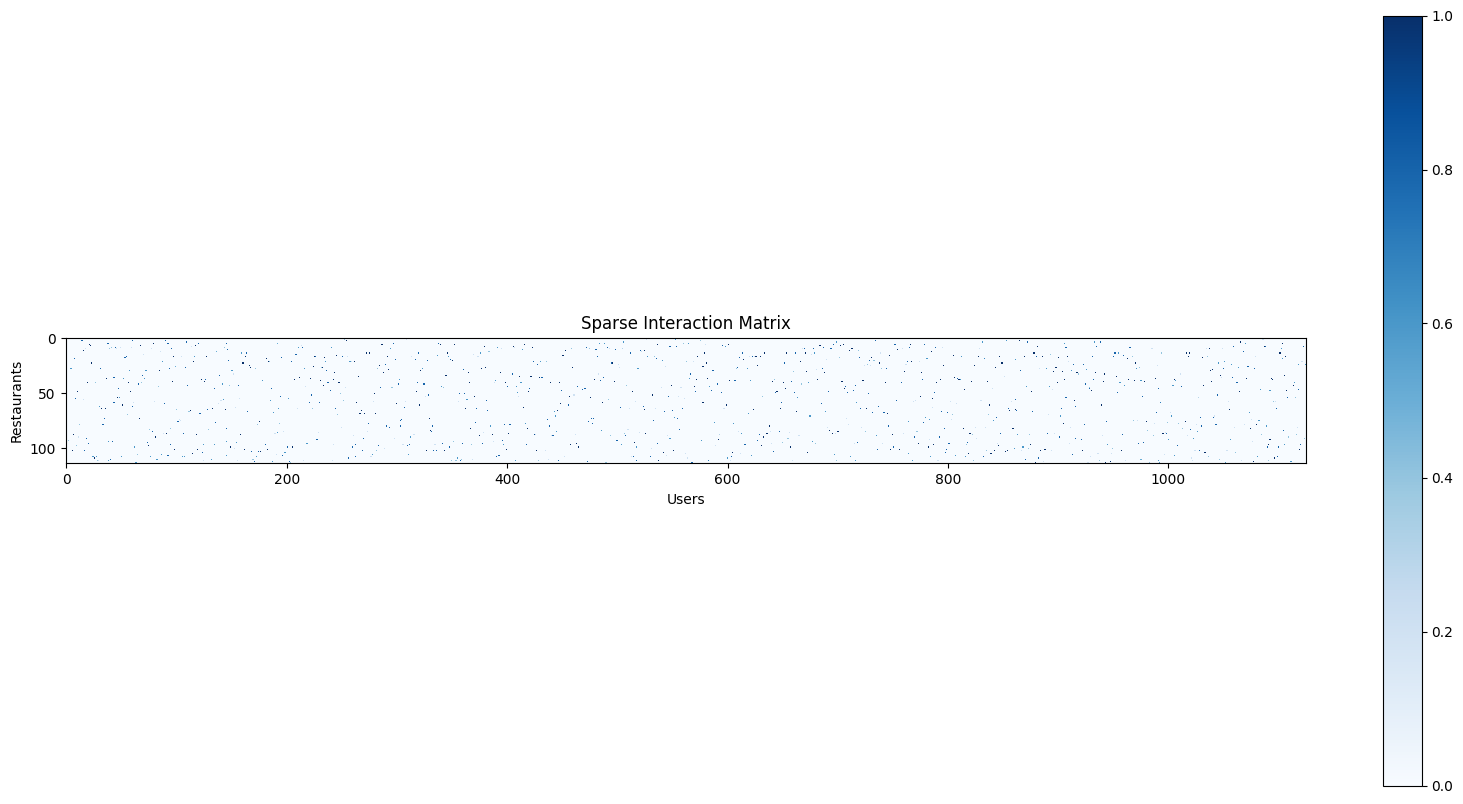

In [76]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.figure(figsize=(20, 10))
plt.imshow(trY, cmap=cm.Blues, interpolation='nearest')
plt.title('Sparse Interaction Matrix')
plt.xlabel('Users')
plt.ylabel('Restaurants')
plt.colorbar()
plt.show()


In [49]:
knn2 = NearestNeighbors(metric='cosine', algorithm='brute')  # Adjust metric and algorithm if needed
knn2.fit(trY)

NearestNeighbors(algorithm='brute', metric='cosine')

In [50]:
# Direct KNN-based recommendation

def similar_restaurants(restaurant_id, k=5):
    restaurant_index = restaurant_rating_df.index.get_loc(restaurant_id)
    restaurant_ratings = trY[restaurant_index]

    distances, indices = knn2.kneighbors(restaurant_ratings.reshape(1, -1), n_neighbors=k+1)
    nearest_neighbors = np.delete(indices[0], np.where(indices[0] == restaurant_index))

    return df_restaurants.iloc[nearest_neighbors]


# def recommend_restaurants_naive(user_id, n_sim=10):
#   restaurants_ids=similar_users(user_id, k=n_sim).idxmax(axis=1)
#   return df_restaurants.loc[df_restaurants['business_id'].isin(restaurants_ids)]


##### Example use

In [51]:
user_to_recommend = df_users.iloc[0]['user_id']  # Testing recommendations with actual user ID
top_restaurant = user_rating_df.loc[user_to_recommend].idxmax()
top_restaurant

'QNoFrASBpqW8dzdAEIYjNQ'

In [52]:
similar_restaurants(top_restaurant)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
110,4IvQU16RBKuLtpgx8yLqmQ,Hunan Palace,6118 Lancaster Ave,Philadelphia,PA,19151,39.983388,-75.244222,4.5,7,1,"{'RestaurantsGoodForGroups': 'True', 'Restaura...",Restaurants,NaN
75,2s5h1TMhYPdRUUNcQFr3WA,California Cafe,160 N Gulph Rd,King of Prussia,PA,19406,40.089393,-75.386031,3.5,16,0,"{'OutdoorSeating': 'False', 'RestaurantsGoodFo...",Restaurants,"{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."
77,d51ICeLySgnQhSRpWJC-pQ,Ventana Mexican Kitchen,"6875 E Sunrise Dr, #101",Tucson,AZ,85750,32.308862,-110.845496,2.0,5,0,"{'BusinessAcceptsCreditCards': 'True', 'GoodFo...",Restaurants,"{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'..."
74,TxYxXvC5RcRRCYR6rbJgEQ,Aspen,747 N 25th St,Philadelphia,PA,19130,39.968780,-75.178154,4.0,7,0,"{'BusinessAcceptsCreditCards': 'True', 'Alcoho...",Restaurants,NaN
79,la8nNJ28dWLFwPUypxmqow,Burger King,3612 Lincoln Hwy,Coatesville,PA,19320,39.995366,-75.748162,1.5,6,0,"{'RestaurantsAttire': ""u'casual'"", 'Restaurant...",Restaurants,NaN


We'll use joblib to persist the two KNNs to the drive

In [53]:
import joblib
joblib.dump(knn, '/content/drive/MyDrive/recommender_dataset/Yelp/knn_user.pkl')
joblib.dump(knn2, '/content/drive/MyDrive/recommender_dataset/Yelp/knn_restaurant.pkl')

['/content/drive/MyDrive/recommender_dataset/Yelp/knn_restaurant.pkl']

We'll write a class named 'RecommenderCF' ( recommender system for collaborative filtering) that manages the loading of those models (taking their paths as parameters) as well as all the functions that we've written so far (for similarity and recommendations, both direct and indirect)


In [54]:
import pandas as pd
import numpy as np
class RecommenderCF:

    def __init__(self, knn_user_path, knn_restaurant_path):
        self.knn_user = joblib.load(knn_user_path)
        self.knn_restaurant = joblib.load(knn_restaurant_path)

    def similar_users_from_ratings(self, user_ratings, k=5, user_index=None):
        user_ratings = fillna(user_ratings)
        distances, indices = self.knn_user.kneighbors(user_ratings.reshape(1, -1), n_neighbors=k+1)
        nearest_neighbors = indices[0] if user_index==None else np.delete(indices[0], np.where(indices[0] == user_index))  # Exclude the user itself

        return user_rating_df.iloc[nearest_neighbors]

    def similar_users_from_id(self, user_id, k=5):
        user_index = user_rating_df.index.get_loc(user_id)
        user_ratings = trX[user_index]
        return self.similar_users_from_ratings(user_ratings,k , user_index)


    def recommend_restaurants_from_id_naive(self, user_id, n_sim=10):
      user_ids = self.similar_users_from_id(user_id, k=n_sim).idxmax(axis=1)
      return df_restaurants.loc[df_restaurants['business_id'].isin(user_ids)]

    def recommend_restaurants_from_ratings_naive(self, user_ratings, n_sim=10):
      restaurants_ids=self.similar_users_from_ratings(user_ratings, k=n_sim).idxmax(axis=1)
      return df_restaurants.loc[df_restaurants['business_id'].isin(restaurants_ids)]


    ##### Extending recommendations beyond best rated restaurant

    def get_top_n_columns_list(self, df, n, column_labels='restaurants'):
      """
      This function takes a pandas DataFrame and an integer n as input and returns a new DataFrame with a single column containing a list of the top n column names with the highest values in each row.

      Args:
        df: A pandas DataFrame.
        n: An integer representing the number of top columns to return.

      Returns:
        A new pandas DataFrame with a single column named "Top N Columns" containing a list of the top n column names with the highest values in each row.
      """

      # Create a new DataFrame with a single column
      top_n_df = pd.DataFrame(columns=["Top " + str(n) + " " + column_labels])

      # Iterate through each row in the DataFrame
      for index, row in df.iterrows():
        # Sort the row in descending order based on its values
        sorted_row = row.sort_values(ascending=False)

        # Select the top n column names
        top_n_columns = sorted_row.index[:n].tolist()

        # Add the top n column names to the new DataFrame
        top_n_df.loc[index, "Top " + str(n) + " " + column_labels] = top_n_columns

      return top_n_df

    def recommend_restaurants_from_id_top(self, user_id, n_sim=10, top_n=5):
      top_restaurants = flatten_n_times(self.get_top_n_columns_list(self.similar_users_from_id(user_id, k=n_sim), top_n).values.tolist())
      return df_restaurants.loc[df_restaurants['business_id'].isin(top_restaurants)]

    def recommend_restaurants_from_ratings_top(self, user_ratings, n_sim=10, top_n=5):
      top_restaurants = flatten_n_times(self.get_top_n_columns_list(self.similar_users_from_ratings(user_ratings, k=n_sim), top_n).values.tolist())
      return df_restaurants.loc[df_restaurants['business_id'].isin(top_restaurants)]

    def similar_restaurants(self, restaurant_id, k=5):
        restaurant_index = restaurant_rating_df.index.get_loc(restaurant_id)
        restaurant_ratings = trY[restaurant_index]

        distances, indices = self.knn_restaurant.kneighbors(restaurant_ratings.reshape(1, -1), n_neighbors=k+1)
        nearest_neighbors = np.delete(indices[0], np.where(indices[0] == restaurant_index))  # Exclude the restaurant itself

        return df_restaurants.iloc[nearest_neighbors]


We show a simple example of how to use that class on a concrete recommendation


In [55]:
recommender = RecommenderCF('/content/drive/MyDrive/recommender_dataset/Yelp/knn_user.pkl','/content/drive/MyDrive/recommender_dataset/Yelp/knn_restaurant.pkl')
user_to_recommend = df_users.iloc[0]['user_id']  # Testing recommendations with actual user ID

List of similar users:

In [56]:
df_users.loc[df_users['user_id'].isin(recommender.similar_users_from_id(user_to_recommend, k=10).index.values)]

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
52,BI4lPhrUpmEySIJUywjIjQ,Dee,1592,2005-07-08 15:21:37,2975,736,1460,"2006,2007,2008,2009,2010,2011,2012,2013","yApfpuLJmEYcXt_lpz_e8w, 4uqrXK9mECd6HsaSAV8_yA...",160,...,17,8,65,46,155,212,208,208,41,47
117,qunxFdBDVl0ordRJEPVNtQ,Lemonjelly,429,2007-04-06 21:36:06,1901,1317,1304,NaN,"NIgHMvhoSsP2nVT-AqVWNg, 5t8ySlAmpQS8P-xFYOu8Aw...",128,...,31,3,5,27,79,100,103,103,115,55
161,8Lc3-TTHjExd79GSQIHnAw,Christopher,627,2006-12-19 07:07:26,615,257,283,NaN,"uqY0yL_zKk-4CcOdEDJ-Ow, 3imjJmcsBveqpSdyTUY5UQ...",31,...,4,8,5,6,24,19,37,37,12,2
557,cs1GMqTt5eGmLqQyPijYcw,Jen,162,2006-06-15 23:14:05,268,214,147,"2006,2007","4ohEUObG716U9GNlMK7eNg, L2g6vS1GDfqLEpiDOFfCkA...",15,...,3,2,14,0,9,10,18,18,3,7
685,PSNakuyRt9i2TS1fz3pp_w,Angela,253,2007-10-09 16:34:18,252,64,70,"2009,2010","fvHiupqwrjwZ9GL8da6xtA, UVxY0iyPaqY7s4BSFtt-xA...",8,...,1,0,0,0,6,7,11,11,6,2
688,XJ5WJPLP-fTIFkza3ChGbA,Robbie,46,2007-04-03 15:06:24,35,18,22,NaN,"8hG50IvPBPpwVGA5HiZkHg, MGIfvuAcgbUtRnhWa_Jm2g...",4,...,0,0,0,0,1,4,4,4,0,0
929,WBmqTb2IrJu9_nIWgZu21g,Catherine,216,2006-02-20 20:43:59,378,101,207,"2006,2007,2008","huowshdRZBhpYV_7mCRM3Q, NZba-Q-Fp10iF77CTQt24Q...",23,...,4,4,3,0,14,27,31,31,10,2
932,WJnEifJRkI6bCH2iw8brFg,Nenette,576,2006-02-07 05:13:06,860,264,478,"2006,2007,2008,2009","umIYHRbXtyb_Yy5uThSD_A, wRGdmKC5Du-lxo01T06Fxg...",39,...,3,1,3,0,9,15,34,34,15,2
1045,J5aAT9bz6KQwfqosRuTt9w,Rebecca,108,2007-07-10 00:06:09,84,24,58,NaN,"57EebK4ybrj9uO3eBq1I3Q, xKD6xH0ga9KsMXDIwz2MCw...",2,...,1,0,1,0,3,5,8,8,4,2
1110,sugA1tq1RD1hflVQZvesIg,Enrique,500,2008-04-23 23:04:19,777,352,466,"2010,2011,2012,2013,2014,2015,2016,2017","Wx7cbLDqYEL3_aVZwh82Ww, mgE3Em0bbFewVaMrADoEHw...",50,...,7,6,0,1,20,53,64,64,37,5


Top recommended restaurant (naive approach)

In [57]:
recommender.recommend_restaurants_from_id_naive(user_to_recommend)


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
109,QNoFrASBpqW8dzdAEIYjNQ,The Brown Pelican,2981 Cliff Dr,Santa Barbara,CA,93109,34.403821,-119.743656,4.0,11,0,"{'BusinessParking': ""{'garage': False, 'street...",Restaurants,NaN


Some dependencies of 'RecommenderCF' like 'restaurant_rating_df', 'trX', 'trY' and 'user_rating_df' should be created in the constructor method (which should thus also take the paths to the initial CSV files) so that the class can be truly portable

In [58]:
import pandas as pd
import numpy as np
class RecommenderCF:

    def __init__(self, knn_user_path, knn_restaurant_path, yelp_review_path, yelp_restaurant_path, yelp_user_path):
        self.knn_user = joblib.load(knn_user_path)
        self.knn_restaurant = joblib.load(knn_restaurant_path)
        review_restaurants = pd.read_csv(yelp_review_path)
        df_users = pd.read_csv(yelp_user_path)
        df_restaurants = pd.read_csv(yelp_restaurant_path)
        combined_df = review_restaurants.merge(df_restaurants, on='business_id')
        combined_df = combined_df.merge(df_users, on='user_id')
        user_rating_df = combined_df.pivot_table(values='stars_x', index='user_id', columns='business_id')
        self.restaurant_rating_df = user_rating_df.T
        user_rating_df.fillna(0, inplace=True)
        norm_user_rating_df = user_rating_df.fillna(0) / 5.0
        self.trX = norm_user_rating_df.values
        self.trY = self.trX.T

    def similar_users_from_ratings(self, user_ratings, k=5, user_index=None):
        user_ratings = fillna(user_ratings)
        distances, indices = self.knn_user.kneighbors(user_ratings.reshape(1, -1), n_neighbors=k+1)
        nearest_neighbors = indices[0] if user_index==None else np.delete(indices[0], np.where(indices[0] == user_index))  # Exclude the user itself

        return user_rating_df.iloc[nearest_neighbors]

    def similar_users_from_id(self, user_id, k=5):
        user_index = user_rating_df.index.get_loc(user_id)
        user_ratings = trX[user_index]
        return self.similar_users_from_ratings(user_ratings,k , user_index)


    def recommend_restaurants_from_id_naive(self, user_id, n_sim=10):
      user_ids = self.similar_users_from_id(user_id, k=n_sim).idxmax(axis=1)
      return df_restaurants.loc[df_restaurants['business_id'].isin(user_ids)]

    def recommend_restaurants_from_ratings_naive(self, user_ratings, n_sim=10):
      restaurants_ids=self.similar_users_from_ratings(user_ratings, k=n_sim).idxmax(axis=1)
      return df_restaurants.loc[df_restaurants['business_id'].isin(restaurants_ids)]


    ##### Extending recommendations beyond best rated restaurant

    def get_top_n_columns_list(self, df, n, column_labels='restaurants'):
      """
      This function takes a pandas DataFrame and an integer n as input and returns a new DataFrame with a single column containing a list of the top n column names with the highest values in each row.

      Args:
        df: A pandas DataFrame.
        n: An integer representing the number of top columns to return.

      Returns:
        A new pandas DataFrame with a single column named "Top N Columns" containing a list of the top n column names with the highest values in each row.
      """

      # Create a new DataFrame with a single column
      top_n_df = pd.DataFrame(columns=["Top " + str(n) + " " + column_labels])

      # Iterate through each row in the DataFrame
      for index, row in df.iterrows():
        # Sort the row in descending order based on its values
        sorted_row = row.sort_values(ascending=False)

        # Select the top n column names
        top_n_columns = sorted_row.index[:n].tolist()

        # Add the top n column names to the new DataFrame
        top_n_df.loc[index, "Top " + str(n) + " " + column_labels] = top_n_columns

      return top_n_df

    def recommend_restaurants_from_id_top(self, user_id, n_sim=10, top_n=5):
      top_restaurants = flatten_n_times(self.get_top_n_columns_list(self.similar_users_from_id(user_id, k=n_sim), top_n).values.tolist())
      return df_restaurants.loc[df_restaurants['business_id'].isin(top_restaurants)]

    def recommend_restaurants_from_ratings_top(self, user_ratings, n_sim=10, top_n=5):
      top_restaurants = flatten_n_times(self.get_top_n_columns_list(self.similar_users_from_ratings(user_ratings, k=n_sim), top_n).values.tolist())
      return df_restaurants.loc[df_restaurants['business_id'].isin(top_restaurants)]

    def similar_restaurants(self, restaurant_id, k=5):
        restaurant_index = restaurant_rating_df.index.get_loc(restaurant_id)
        restaurant_ratings = trY[restaurant_index]

        distances, indices = self.knn_restaurant.kneighbors(restaurant_ratings.reshape(1, -1), n_neighbors=k+1)
        nearest_neighbors = np.delete(indices[0], np.where(indices[0] == restaurant_index))  # Exclude the restaurant itself

        return df_restaurants.iloc[nearest_neighbors]



In [59]:
restaurant_rating_df_path = '/content/drive/MyDrive/recommender_dataset/Yelp/knn_user.pkl'
knn_restaurant_path = '/content/drive/MyDrive/recommender_dataset/Yelp/knn_restaurant.pkl'
review_restaurants_path = '/content/drive/MyDrive/recommender_dataset/Yelp/yelp_dataset/yelp_review_restaurants.csv'
restaurants_path = '/content/drive/MyDrive/recommender_dataset/Yelp/yelp_dataset/yelp_restaurants.csv'
users_path = '/content/drive/MyDrive/recommender_dataset/Yelp/yelp_dataset/yelp_users.csv'

recommender = RecommenderCF(restaurant_rating_df_path, knn_restaurant_path, review_restaurants_path, restaurants_path, users_path)

user_to_recommend = df_users.iloc[0]['user_id']  # Testing recommendations with actual user ID

# List of similar users:
df_users.loc[df_users['user_id'].isin(recommender.similar_users_from_id(user_to_recommend, k=10).index.values)]
# Top recommended restaurant (naive approach)
recommender.recommend_restaurants_from_id_naive(user_to_recommend)


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
109,QNoFrASBpqW8dzdAEIYjNQ,The Brown Pelican,2981 Cliff Dr,Santa Barbara,CA,93109,34.403821,-119.743656,4.0,11,0,"{'BusinessParking': ""{'garage': False, 'street...",Restaurants,NaN


# Graphical User Interface

## General restaurants display

In [60]:
df_photos = pd.read_csv('/content/drive/MyDrive/recommender_dataset/Yelp/yelp_dataset/yelp_photos.csv')


In [61]:
import numpy as np
df_photos['photo_id'] = df_photos['photo_id'].replace('#NAME?', np.nan)


In [62]:
from ipywidgets import HTML, Layout, TwoByTwoLayout, GridspecLayout
from ipywidgets import Image, HBox, VBox, Layout, Text, Output, IntSlider, Button, Combobox, Dropdown, Select
from ipyleaflet import Map, Marker, Popup, LayerGroup, SearchControl, ScaleControl, AwesomeIcon


In [63]:


# Merge restaurants and photos

restaurants_photos = df_restaurants.merge(df_photos, how='left', on='business_id')

# Display images
def restaurant_img(restaurant, img_w=100, img_h=100):
    if restaurant['photo_id'] is not np.nan:
        img_path = '/content/drive/MyDrive/recommender_dataset/Yelp/photos/' + restaurant['photo_id'] + '.jpg'
    else:
        img_path = '/content/drive/MyDrive/recommender_dataset/Yelp/yelp_dataset/imgs/not_found.jpg'

    with open(img_path, "rb") as f:
            image_bytes = f.read()
            img_widget = Image(value=image_bytes,
                    format='png',
                    )
            img_widget.layout.width = f"{img_w}px"
            img_widget.layout.height = f"{img_h}px"
            return img_widget

for restaurant_index, restaurant in restaurants_photos.head(5).iterrows():
    img = restaurant_img(restaurant)

    vbox = VBox([img, Text(restaurant['name'])])
    display(vbox)

Simple star rating component:

In [64]:
def star_rating_static(value=0, num_reviews=0):
  rating_html = ''.join([f"""<span style="color: {'#f90' if i < value else '#ccc'};">&#9733</span>""" for i in range(5)])
  return HTML(f"<h2 style='width: inherit; overflow-wrap: break-word;'>{rating_html} ({num_reviews} reviews)</h2>")

Restaurant popup

In [65]:

def get_restaurant_popup(restaurant, img_w=125, img_h=200):
  """Returns an HTML string template for a popup displaying the most relevant attributes of a restaurant."""

  thumbnail = restaurant_img(restaurant, img_w=img_w, img_h=img_h)
  description = HTML(f"""
  <div style="width: 125px; overflow-wrap: break-word;">
    <h2>{restaurant['name']}</h2>
    <br>
    <b>{restaurant['address']}, {restaurant['city']}</b>
    <br>
     {'(Open)' if restaurant['is_open'] else '(Closed)'}
  </div>
  """)
  rating = star_rating_static(value=restaurant['stars'], num_reviews=restaurant['review_count'])

  grid = GridspecLayout(6, 6, width='500px',height='300px')
  grid[:3, 2:] = description
  grid[:3, :2] = thumbnail
  grid[4, :] = rating

  return grid



In [66]:
# Create a map
m = Map(center=(39.99395569397331, -75.13861180903687), zoom=5, layout=Layout(width='100%', height='600px'))

marker = Marker(icon=AwesomeIcon(name="check", marker_color='green', icon_color='darkgreen'))

m.add(SearchControl(
  position="topleft",
  url='https://nominatim.openstreetmap.org/search?format=json&q={s}',
  zoom=5,
  marker=marker
))

m.add(ScaleControl(position='bottomleft'))


# Add a layer for the restaurants
restaurants_layer = LayerGroup()
for restaurant in restaurants_photos.head(10).iterrows():
  restaurant_location = (restaurant[1]['latitude'], restaurant[1]['longitude'])
  restaurant_marker = Marker(location=restaurant_location, draggable=False)
  restaurant_marker.popup = get_restaurant_popup(restaurant[1], img_w=200)

  restaurants_layer.add_layer(restaurant_marker)

# Add the layer to the map
m.add_layer(restaurants_layer)

# Display the map
display(m)

Map(center=[39.99395569397331, -75.13861180903687], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [67]:
from ipyleaflet import MarkerCluster

m2 = Map(center=(39.99395569397331, -75.13861180903687), zoom=5, layout=Layout(width='100%', height='600px'))

marker = Marker(icon=AwesomeIcon(name="check", marker_color='green', icon_color='darkgreen'))

m2.add(SearchControl(
  position="topleft",
  url='https://nominatim.openstreetmap.org/search?format=json&q={s}',
  zoom=5,
  marker=marker
))

m2.add(ScaleControl(position='bottomleft'))


# Add a layer for the restaurants
restaurants_markers = []
for restaurant in restaurants_photos.iterrows():
  restaurant_location = (restaurant[1]['latitude'], restaurant[1]['longitude'])

  restaurant_marker = Marker(location=restaurant_location, draggable=False)
  restaurant_marker.popup = get_restaurant_popup(restaurant[1], img_w=200)

  restaurants_markers.append(restaurant_marker)

  restaurants_layer.add_layer(restaurant_marker)


marker_cluster = MarkerCluster(
    markers=restaurants_markers
)

# Add the layer to the map
m2.add_layer(marker_cluster)

# # Create a marker cluster
# marker_cluster = MarkerCluster(markers=restaurants_layer)

# # Add the marker cluster to the map
# m2.add_layer(marker_cluster)

# Display the map
display(m2)


Map(center=[39.99395569397331, -75.13861180903687], controls=(ZoomControl(options=['position', 'zoom_in_text',…

## Recommender GUI

### Restaurant Rating component

In [68]:
def restaurant_rater(business_index):
  return Dropdown(
    placeholder='Rating',
    options=[('Unrated', 0)] + [('⭐'*i + f" ({i}/5)", i) for i in range(1,6)],
    description=df_restaurants.iloc[business_index]['name'],
    ensure_option=True,
    disabled=False
)

In [69]:
restaurant_rater(6)

Dropdown(description='Curry In A Hurry', options=(('Unrated', 0), ('⭐ (1/5)', 1), ('⭐⭐ (2/5)', 2), ('⭐⭐⭐ (3/5)…

Let's display these components in a vertical carousel:

In [70]:
from ipywidgets import Layout, Button, VBox, Label, Box
from random import sample

def restaurant_raters(ids=sample(range(114), 10)):
  item_layout = Layout(height='100px', min_width='40px')
  items = [restaurant_rater(i) for i in ids]
  box_layout = Layout(overflow='scroll hidden',
                      border='3px solid black',
                      width='500px',
                      height='200px',
                      flex_flow='column')
  ratings_carousel = Box(children=items, layout=box_layout)
  return VBox([HTML(
      value="<h2>Rate these restaurants:</h2>",
      placeholder='',
      description='',
  ), ratings_carousel]), ratings_carousel


random_ids = sample(range(114), 5)

raters_ui, ratings_carousel = restaurant_raters(random_ids)
raters_ui

Ratings can be trivially accessed through the reference to the individual rating components, which have trait attributes; so they can track changes to the UI

In [71]:
np.array([rater.value for rater in ratings_carousel.children])

array([0, 0, 0, 0, 0])

However, we need to recover those ratings while preserving the business's index information. We'll take advantage of NumPy's ability to index arrays with lists, allowing us to update multiple values at once efficiently.

The true ratings vector would thus be:

In [72]:
temp_ratings = np.zeros(len(df_restaurants))
temp_ratings[random_ids] = np.array([rater.value for rater in ratings_carousel.children])
temp_ratings

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

...and this array can be passed to the recommender system !

In [73]:
random_ids

[75, 97, 5, 68, 110]

In [74]:
recommender.recommend_restaurants_from_ratings_top(temp_ratings).index

Index([2, 11, 18, 30, 33, 35, 43, 57, 60, 61, 63, 69, 70, 79, 82, 86, 97, 98,
       103, 107],
      dtype='int64')

### Putting it all together

In [75]:

# Store user ratings
user_ratings = np.zeros(len(df_restaurants))
current_restaurants = sample(range(114), 5)

# Define interactive GUI elements
# map_display = Output(layout=Layout(height='200px', width='200px', overflow_y='scroll'))  # Set the maximum height here

raters, carousel = restaurant_raters(current_restaurants)
raters_display = Output(layout=Layout(height='500px'))
suggest_button = Button(description='Rate Restaurants')

# Initial display
with raters_display:
    raters_display.clear_output(wait=True)
    display(raters, width=500, height=500)

# with map_display:
#     display(m)

# Define layout structure
layout = VBox([raters_display, suggest_button])

# Display the GUI
display(layout)

def suggest_restaurants(b):
    global user_ratings, current_restaurants, carousel, raters, raters_display

    user_ratings[current_restaurants] = np.array([rater.value for rater in carousel.children])

    current_restaurants = recommender.recommend_restaurants_from_ratings_top(user_ratings, ).index

    raters, carousel = restaurant_raters(current_restaurants)


    # Suggest new batch of restaurants
    with raters_display:
      raters_display.clear_output(wait=True)
      display(restaurant_raters(current_restaurants)[0])


# Assign the suggest_song function to the button click event
suggest_button.on_click(suggest_restaurants)